In [1]:
# import librairies
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math as math
import time
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = [14, 14]


# Recommendation engine with a graph
>The purpose is to build a recommendation engine based on graph by using the Adamic Adar measure.<br/> The more the measure is high, the closest are the two nodes.<br/> The measures between all movies are NOT pre-calculated, in order to determine the list of recommendation films, we are going to explore the neighborhood of the target film

# How to take in account of the description ?

#### First idea ...
> In order to take in account the description, the movie are clustered by applying a KMeans clustering with TF-IDF weights <br/> So two movies that belong in a group of description will share a node.<br/> The fewer the number of films in the group, the more this link will be taken into account 

**but it doesn't work because clusters are too unbalanced*

#### Second idea ...
> In order to take in account the description, calcul the TF-IDF matrix <br/> and for each film, take the top 5 of similar descriptions and create a node Similar_to_this. This node will be taken in account in the Adamic Adar measure.

I have publish a notebook that explains what is "KMeans clustering with TF-IDF" here :
https://www.kaggle.com/yclaudel/find-similar-articles-with-tf-idf

# Adamic Adar measure
It is a measure used to compute the closeness of nodes based on their shared neighbors.

* x and y are 2 nodes (2 Movies)
* N(one_node) is a function that return the set of adjacent nodes  to one_node

$$ adamicAdar(x,y)=  \sum_{ u \in N(x) \cap N(y)} \frac{1}{log(N(u))}  $$

<span>&#171;</span>say otherwise, for each node u in common to x and y, add to the measure 1/log(N(u))<span>&#187;</span>

The quantity $ \frac{1}{log(N(u))} $ determine the importance of u in the measure.
* if x and y share a node u that has a lot of adjacent nodes, this node is not really relevant. <span>&#8594;</span> N(u) is high <span>&#8594;</span> 1/log(N(u)) is not high
* if x and y share a node u that **not** has a lot of adjacent nodes, this node is **really** relevant. <span>&#8594;</span> N(u) is **not** high <span>&#8594;</span> 1/log(N(u)) is higher


# Load the data

In [2]:
# load the data
df = pd.read_csv('netflix_titles.csv')
# convert to datetime
df["date_added"] = pd.to_datetime(df['date_added'])
df['year'] = df['date_added'].dt.year
df['month'] = df['date_added'].dt.month
df['day'] = df['date_added'].dt.day
# convert columns "director, listed_in, cast and country" in columns that contain a real list
# the strip function is applied on the elements
# if the value is NaN, the new column contains a empty list []
df['directors'] = df['director'].apply(lambda l: [] if pd.isna(l) else [
                                       i.strip() for i in l.split(",")])
df['categories'] = df['listed_in'].apply(lambda l: [] if pd.isna(l) else [
                                         i.strip() for i in l.split(",")])
df['actors'] = df['cast'].apply(lambda l: [] if pd.isna(l) else [
                                i.strip() for i in l.split(",")])
df['countries'] = df['country'].apply(lambda l: [] if pd.isna(l) else [
                                      i.strip() for i in l.split(",")])

df.head()


,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,year,month,day,directors,categories,actors,countries
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,2021-09-25,2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm...",2021.0,9.0,25.0,[Kirsten Johnson],[Documentaries],[],[United States]
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,2021-09-24,2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t...",2021.0,9.0,24.0,[],"[International TV Shows, TV Dramas, TV Mysteries]","[Ama Qamata, Khosi Ngema, Gail Mabalane, Thaba...",[South Africa]
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,2021-09-24,2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...,2021.0,9.0,24.0,[Julien Leclercq],"[Crime TV Shows, International TV Shows, TV Ac...","[Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nab...",[]
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,2021-09-24,2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo...",2021.0,9.0,24.0,[],"[Docuseries, Reality TV]",[],[]
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,2021-09-24,2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...,2021.0,9.0,24.0,[],"[International TV Shows, Romantic TV Shows, TV...","[Mayur More, Jitendra Kumar, Ranjan Raj, Alam ...",[India]


In [3]:
print(df.shape)


(8807, 19)


# KMeans clustering with TF-IDF

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn.cluster import MiniBatchKMeans

# Build the tfidf matrix with the descriptions
start_time = time.time()
text_content = df['description']
vector = TfidfVectorizer(max_df=0.4,         # drop words that occur in more than X percent of documents
                         min_df=1,      # only use words that appear at least X times
                         stop_words='english',  # remove stop words
                         lowercase=True,  # Convert everything to lower case
                         use_idf=True,   # Use idf
                         norm=u'l2',     # Normalization
                         smooth_idf=True,  # Prevents divide-by-zero errors
                         ngram_range=(1, 3)
                         )
tfidf = vector.fit_transform(text_content)

# Clustering  Kmeans
k = 200
kmeans = MiniBatchKMeans(n_clusters=k)
kmeans.fit(tfidf)
centers = kmeans.cluster_centers_.argsort()[:, ::-1]
terms = vector.get_feature_names()

# print the centers of the clusters
# for i in range(0,k):
#     word_list=[]
#     print("cluster%d:"% i)
#     for j in centers[i,:10]:
#         word_list.append(terms[j])
#     print(word_list)

request_transform = vector.transform(df['description'])
# new column cluster based on the description
df['cluster'] = kmeans.predict(request_transform)

df['cluster'].value_counts().head()


C:\tools\miniconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


80     8454
95      152
134       2
5         2
181       2
Name: cluster, dtype: int64

<div class="alert alert-block alert-warning"><span>&#171;</span>column cluster are not going to be used because clusters are two unbalanced <br/> But tfidf will be used in order to find similar description<span>&#187;</span></div>

In [5]:
# Find similar : get the top_n movies with description similar to the target description
def find_similar(tfidf_matrix, index, top_n=5):
    cosine_similarities = linear_kernel(
        tfidf_matrix[index:index+1], tfidf_matrix).flatten()
    related_docs_indices = [i for i in cosine_similarities.argsort()[
        ::-1] if i != index]
    return [index for index in related_docs_indices][0:top_n]


# Load the graph (undirected graph)
Nodes are :
* Movies
* Person ( actor or director)
* Categorie
* Countrie
* Cluster (description)
* Sim(title) top 5 similar movies in the sense of the description

Edges are :
* ACTED_IN : relation between an actor and a movie
* CAT_IN : relation between a categrie and a movie
* DIRECTED : relation between a director and a movie
* COU_IN : relation between a country and a movie
* DESCRIPTION : relation between a cluster and a movie
* SIMILARITY in the sense of the description

<span>&#171;</span>so, two movies are not directly connected, but they share persons, categories,clusters and countries<span>&#187;</span>


In [6]:
G = nx.Graph(label="MOVIE")
start_time = time.time()
for i, rowi in df.iterrows():
    if (i % 1000 == 0):
        print(" iter {} -- {} seconds --".format(i, time.time() - start_time))
    G.add_node(rowi['title'], key=rowi['show_id'], label="MOVIE",
               mtype=rowi['type'], rating=rowi['rating'])
#    G.add_node(rowi['cluster'],label="CLUSTER")
#    G.add_edge(rowi['title'], rowi['cluster'], label="DESCRIPTION")
    for element in rowi['actors']:
        G.add_node(element, label="PERSON")
        G.add_edge(rowi['title'], element, label="ACTED_IN")
    for element in rowi['categories']:
        G.add_node(element, label="CAT")
        G.add_edge(rowi['title'], element, label="CAT_IN")
    for element in rowi['directors']:
        G.add_node(element, label="PERSON")
        G.add_edge(rowi['title'], element, label="DIRECTED")
    for element in rowi['countries']:
        G.add_node(element, label="COU")
        G.add_edge(rowi['title'], element, label="COU_IN")

    indices = find_similar(tfidf, i, top_n=5)
    snode = "Sim("+rowi['title'][:15].strip()+")"
    G.add_node(snode, label="SIMILAR")
    G.add_edge(rowi['title'], snode, label="SIMILARITY")
    for element in indices:
        G.add_edge(snode, df['title'].loc[element], label="SIMILARITY")
print(" finish -- {} seconds --".format(time.time() - start_time))


 iter 0 -- 0.05301165580749512 seconds --
 iter 1000 -- 8.058001279830933 seconds --
 iter 2000 -- 15.945759534835815 seconds --
 iter 3000 -- 23.73951029777527 seconds --
 iter 4000 -- 31.51925754547119 seconds --
 iter 5000 -- 39.30600714683533 seconds --
 iter 6000 -- 47.330456256866455 seconds --
 iter 7000 -- 55.83936882019043 seconds --
 iter 8000 -- 63.923184394836426 seconds --
 finish -- 70.21759796142578 seconds --


# To see what's going on,a sub-graph with only two movies ...

In [7]:
def get_all_adj_nodes(list_in):
    sub_graph = set()
    for m in list_in:
        sub_graph.add(m)
        for e in G.neighbors(m):
            sub_graph.add(e)
    return list(sub_graph)


def draw_sub_graph(sub_graph):
    subgraph = G.subgraph(sub_graph)
    colors = []
    for e in subgraph.nodes():
        if G.nodes[e]['label'] == "MOVIE":
            colors.append('blue')
        elif G.nodes[e]['label'] == "PERSON":
            colors.append('red')
        elif G.nodes[e]['label'] == "CAT":
            colors.append('green')
        elif G.nodes[e]['label'] == "COU":
            colors.append('yellow')
        elif G.nodes[e]['label'] == "SIMILAR":
            colors.append('orange')
        elif G.nodes[e]['label'] == "CLUSTER":
            colors.append('orange')

    nx.draw(subgraph, with_labels=True, font_weight='bold', node_color=colors)
    plt.show()


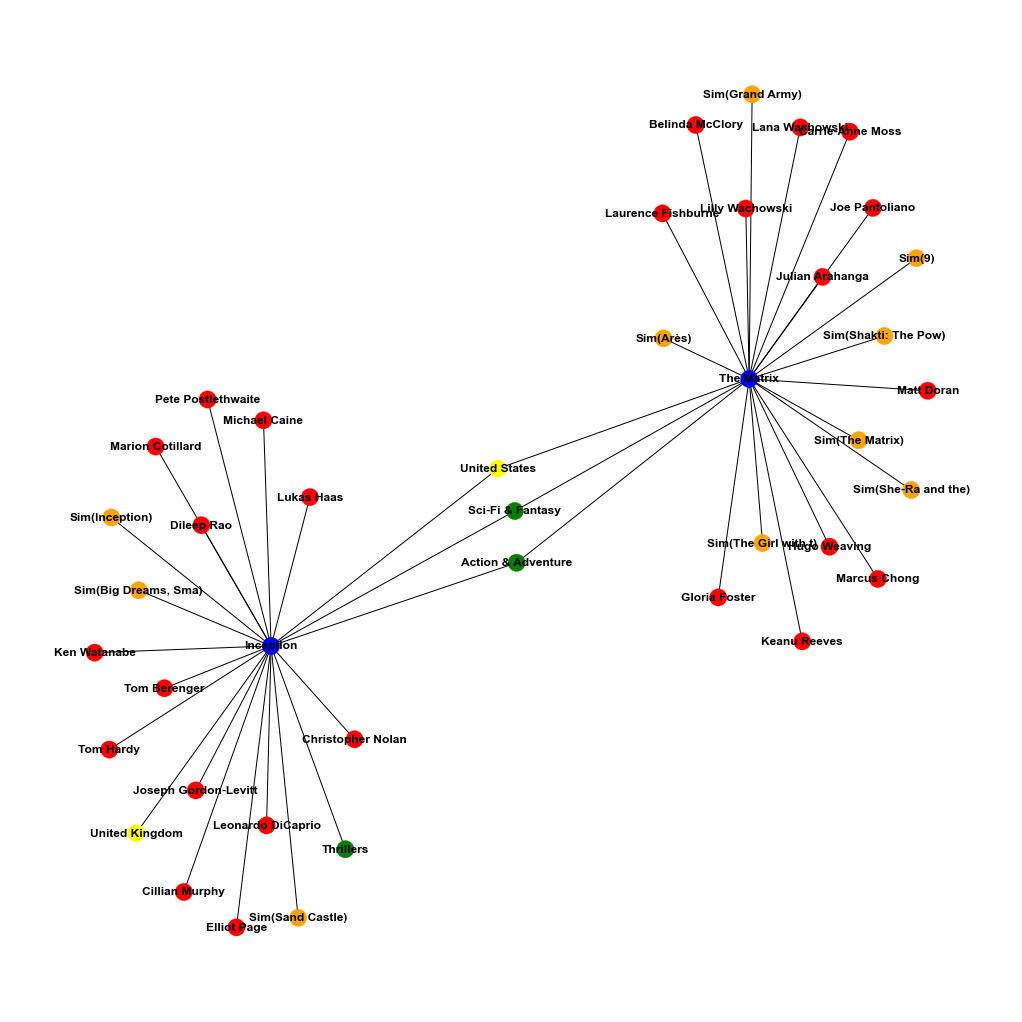

In [17]:
list_in = ["The Matrix", "Inception"]
sub_graph = get_all_adj_nodes(list_in)
draw_sub_graph(sub_graph)


# The recommendation function
<div class="alert alert-block alert-info">
<li> Explore the neighborhood of the target film <span>&#8594;</span> this is a list of actor, director, country, categorie</li>
<li> Explore the neighborhood of each neighbor <span>&#8594;</span> discover the movies that share a node with the target field</li>
<li> Calcul Adamic Adar measure <span>&#8594;</span> final results</li>
</div>

In [9]:
def get_recommendation(root):
    commons_dict = {}
    for e in G.neighbors(root):
        for e2 in G.neighbors(e):
            if e2 == root:
                continue
            if G.nodes[e2]['label'] == "MOVIE":
                commons = commons_dict.get(e2)
                if commons == None:
                    commons_dict.update({e2: [e]})
                else:
                    commons.append(e)
                    commons_dict.update({e2: commons})
    movies = []
    weight = []
    for key, values in commons_dict.items():
        w = 0.0
        for e in values:
            w = w+1/math.log(G.degree(e))
        movies.append(key)
        weight.append(w)

    result = pd.Series(data=np.array(weight), index=movies)
    result.sort_values(inplace=True, ascending=False)
    return result


# Let's test it ...

In [15]:
result = get_recommendation("The Matrix")
result2 = get_recommendation("Jaws")
result3 = get_recommendation("Inception")
result4 = get_recommendation("Stranger Things")
print("*"*40+"\n Recommendation for 'Ocean's Twelve'\n"+"*"*40)
print(result.head())
print("*"*40+"\n Recommendation for 'Ocean's Thirteen'\n"+"*"*40)
print(result2.head())
print("*"*40+"\n Recommendation for 'Belmonte'\n"+"*"*40)
print(result3.head())
print("*"*40+"\n Recommendation for 'Stranger Things'\n"+"*"*40)
print(result4.head())


****************************************
 Recommendation for 'Ocean's Twelve'
****************************************
The Matrix Reloaded       4.876690
The Matrix Revolutions    3.433995
Cloud Atlas               1.993342
Grand Army                1.796084
Jupiter Ascending         1.694492
dtype: float64
****************************************
 Recommendation for 'Ocean's Thirteen'
****************************************
Jaws 2               7.720816
Jaws: The Revenge    5.086788
Jaws 3               2.502217
Soul Surfer          1.366271
Cheer Squad          1.237974
dtype: float64
****************************************
 Recommendation for 'Belmonte'
****************************************
The Little Prince    1.564448
Apostle              1.544690
Brick                1.455506
Peaky Blinders       1.428888
Transcendence        1.331864
dtype: float64
****************************************
 Recommendation for 'Stranger Things'
****************************************
Beyond 

# Draw top recommendations, to see the common nodes

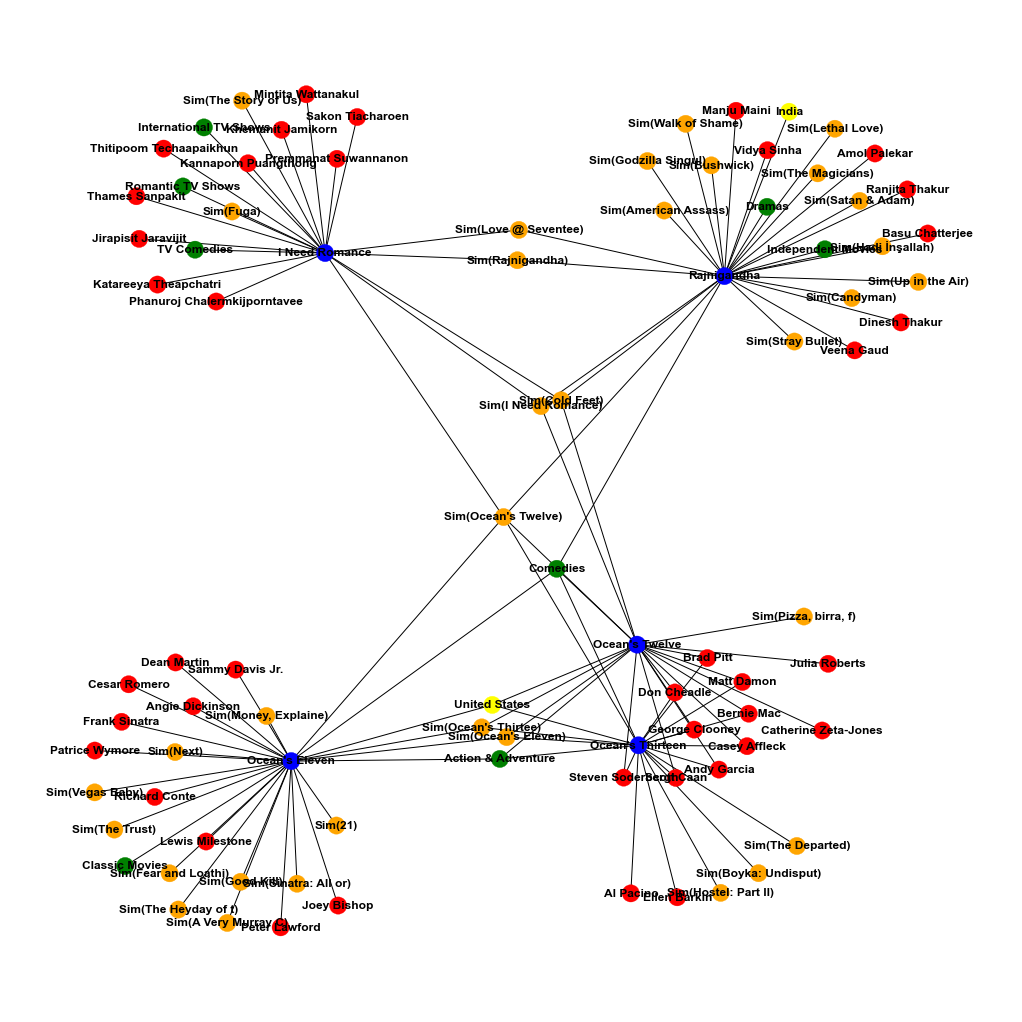

In [11]:
reco = list(result.index[:4].values)
reco.extend(["Ocean's Twelve"])
sub_graph = get_all_adj_nodes(reco)
draw_sub_graph(sub_graph)


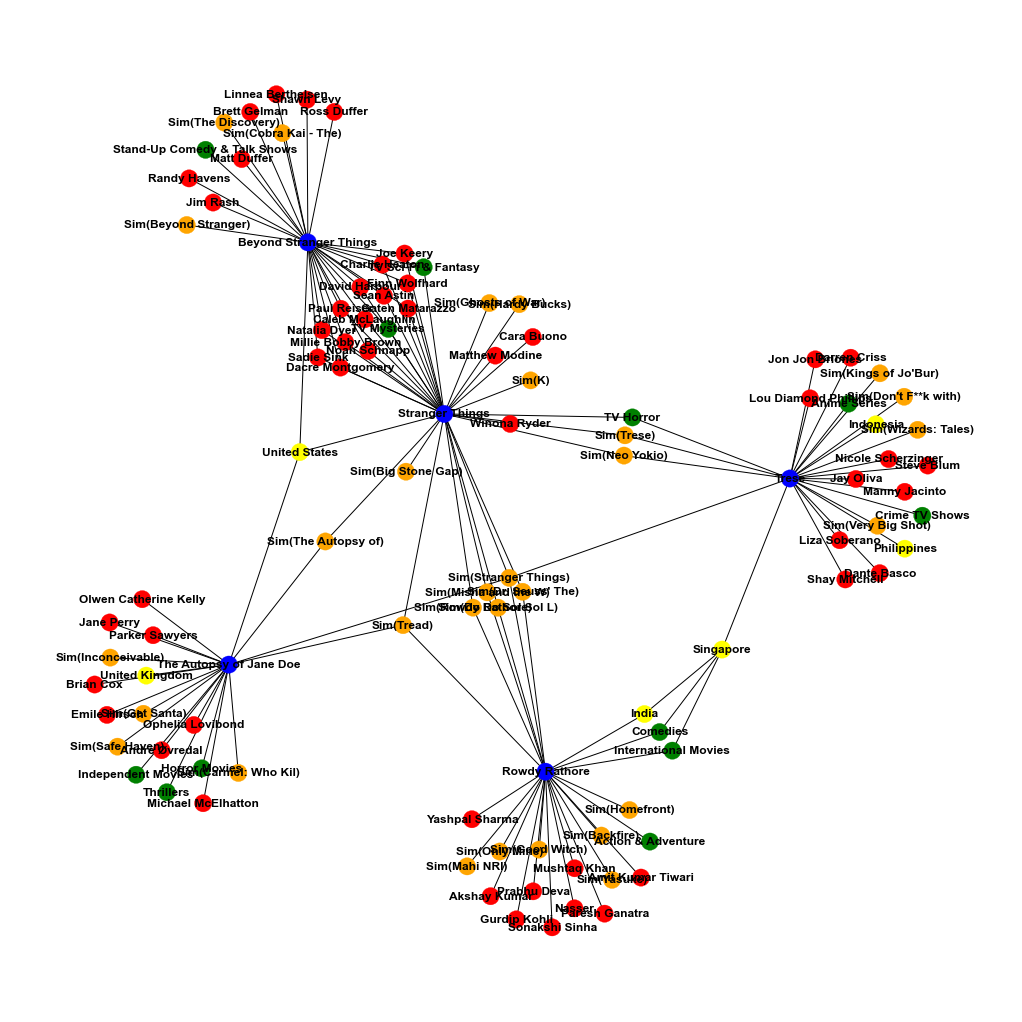

In [12]:
reco = list(result4.index[:4].values)
reco.extend(["Stranger Things"])
sub_graph = get_all_adj_nodes(reco)
draw_sub_graph(sub_graph)


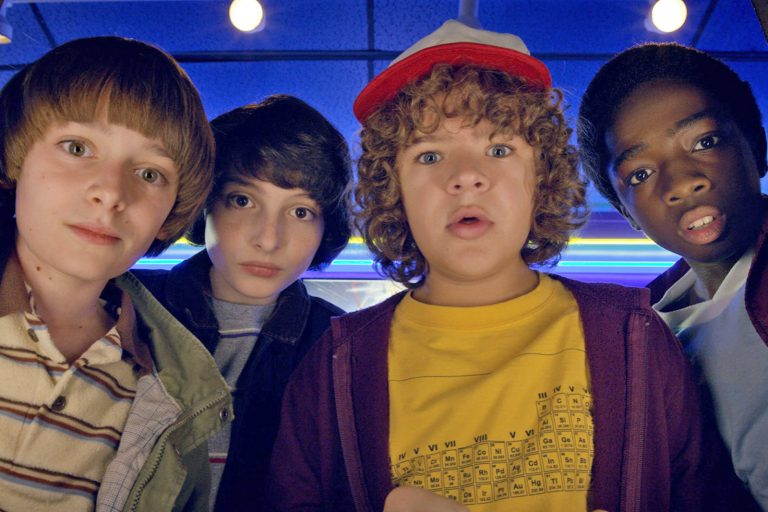

<div class="alert alert-block alert-info"><b><span>&#171;</span> please don't forget to upvote, that will keep me motivated <span>&#187;</span></b></div> 